In [1]:
import wrf
# from wrf import getvar, ALL_TIMES, latlon_coords, CoordPair, vertcross 
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from datetime import datetime, timedelta
# import nc_time_axis
# from cftime import DatetimeNoLeap
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import math
from math import cos, asin, sqrt, pi

%matplotlib inline
%config InlineBackend.figure_format='retina'


#### Read in variables

In [ ]:
parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl'
file_d01_metadata = parent_dir + '/wrfout_d01_2013-11-01_00:00:00'
file_d02_metadata = parent_dir + '/wrfout_d02_2013-11-01_00:00:00'

# 3-D data
file_d02_U = parent_dir + '/post/d02/U.nc'				# Zonal wind [m/s]
file_d02_V = parent_dir + '/post/d02/V.nc'				# Meridional wind [m/s]

# 2-D data
file_d02_RR = parent_dir + '/post/d02/RAINNC.nc'		# Rain Rate [mm/hr]
file_d02_AVOR = parent_dir + '/post/d02/AVOR.nc'		# Absolute Vorticity [10-5 s-1]
file_d02_SLP = parent_dir + '/post/d02/SLP.nc'			# Sea Level Pressure [hPa]
file_d02_U10 = parent_dir + '/post/d02/U10.nc'				# Zonal wind [m/s] @ 10m
file_d02_V10 = parent_dir + '/post/d02/V10.nc'				# Meridional wind [m/s] @ 10m

# JTWC best track
file_JTWC_track = '/home/hragnajarian/code_analysis/General/bwp312013.dat'

######################################################################################
t = 97  # t is the number of timesteps you want to include i.e. t = 24 == 24 hours
# This is employed for debugging purposes so we don't use all the memory
######################################################################################

# Raw datasets
ds_d01 = xr.open_dataset(file_d01_metadata).isel(Time=slice(0,t))
ds_d02 = xr.open_dataset(file_d02_metadata).isel(Time=slice(0,t))

######################################################################################
############################## Coordinate dictionaries ###############################
######################################################################################

timesteps = np.arange('2013-11-01 00:00:00','2013-11-05 01:00:00', dtype='datetime64[h]')
# timesteps = np.arange('2013-11-01 00:00:00','2013-11-01 06:00:00', dtype='datetime64[h]')
P_levels = np.arange(1000,0,-50)
d01_XLONG = ds_d01.XLONG.values
d01_XLONG[d01_XLONG<0]=d01_XLONG[d01_XLONG<0]+360
d01_coords = dict(
	XLAT = (('lat','lon'),ds_d01.XLAT[0,...].values),
	XLONG = (('lat','lon'),d01_XLONG[0,...]),
	time = ('time',timesteps),
	level = ('level',P_levels),
	lat = ('lat',ds_d01.XLAT[0,:,0].values),
	lon = ('lon',d01_XLONG[0,0,:])
)
d02_XLONG = ds_d02.XLONG.values
d02_XLONG[d02_XLONG<0]=d02_XLONG[d02_XLONG<0]+360
d02_coords = dict(
	time = ('time',timesteps),
	XLAT = (('lat','lon'),ds_d02.XLAT[0,...].values),
	XLONG = (('lat','lon'),d02_XLONG[0,...]),
	level = ('level',P_levels),
	lat = ('lat',ds_d02.XLAT[0,:,0].values),
	lon = ('lon',d02_XLONG[0,0,:])
)
# Function that can removes the levels dimension for 2-D datasets
def without_keys(d, keys):
	return {x: d[x] for x in d if x not in keys}

######################################################################################
##################################### Variables ######################################
######################################################################################

#####################################################
######################## 3-D ########################
#####################################################
# # Zonal Wind [m/s]
# ds = xr.open_dataset(file_d02_U).isel(time=slice(0,t))
# da_d02_U = ds['U'].compute()
# da_d02_U = da_d02_U.assign_coords(d02_coords)

# # Meridional Wind [m/s]
# ds = xr.open_dataset(file_d02_V).isel(time=slice(0,t))
# da_d02_V = ds['V'].compute()
# da_d02_V = da_d02_V.assign_coords(d02_coords)

#####################################################
######################## 2-D ########################
#####################################################
# Rain rate [mm/hr]
ds = xr.open_dataset(file_d02_RR).isel(time=slice(0,t))
da_d02_RR = ds['RAINNC'].compute().squeeze()
a = da_d02_RR[1:].values - da_d02_RR[:-1].values	# Subtract to get hourly differences
da_d02_RR = np.append(np.expand_dims(da_d02_RR[0], axis=0), a, axis=0)
da_d02_RR = xr.DataArray(da_d02_RR*24,	# Convert to [mm/day]
						  dims=['time','lat','lon'],
						  coords=without_keys(d02_coords,'level'))

# Absolute Vorticity [10-5 s-1]
ds = xr.open_dataset(file_d02_AVOR).isel(time=slice(0,t),level=3)	# index 3 = 850, index 6 = 700
da_d02_AVOR_850 = ds['AVOR'].compute().squeeze()*(10**-5)			# Convert to [s-1]
da_d02_AVOR_850 = da_d02_AVOR_850.assign_coords(without_keys(d02_coords,'level'))
# Calculate relative vorticity
coriolis_parameter = np.zeros(da_d02_AVOR_850.shape)
omega_E = 7.292*(10**-5)	# Earth's rotation [radians/s]
for tidx in range(coriolis_parameter.shape[0]):		# loop through times
	for i in range(coriolis_parameter.shape[1]):	# loop through latitudes
		coriolis_parameter[tidx,i,:] = 2*omega_E*math.sin(math.radians(da_d02_AVOR_850.lat.values[i]))
da_d02_RVOR_850 = da_d02_AVOR_850 - coriolis_parameter

# Sea Level Pressure [hPa]
ds = xr.open_dataset(file_d02_SLP).isel(time=slice(0,t))
da_d02_SLP = ds['SLP'].compute().squeeze()
da_d02_SLP = da_d02_SLP.assign_coords(without_keys(d02_coords,'level'))

# Zonal Wind [m/s] @ 10m
ds = xr.open_dataset(file_d02_U10).isel(time=slice(0,t))
da_d02_U10 = ds['U10'].compute().squeeze()
da_d02_U10 = da_d02_U10.assign_coords(without_keys(d02_coords,'level'))

# Meridional Wind [m/s] @ 10m
ds = xr.open_dataset(file_d02_V10).isel(time=slice(0,t))
da_d02_V10 = ds['V10'].compute().squeeze()
da_d02_V10 = da_d02_V10.assign_coords(without_keys(d02_coords,'level'))

#### Plot the domain area

In [19]:
ds_d02.XLONG.values

array([[[144.02167, 144.05283, 144.08398, ..., 181.31815, 181.3493 ,
         181.38046],
        [144.02167, 144.05283, 144.08398, ..., 181.31815, 181.3493 ,
         181.38046],
        [144.02167, 144.05283, 144.08398, ..., 181.31815, 181.3493 ,
         181.38046],
        ...,
        [144.02167, 144.05283, 144.08398, ..., 181.31815, 181.3493 ,
         181.38046],
        [144.02167, 144.05283, 144.08398, ..., 181.31815, 181.3493 ,
         181.38046],
        [144.02167, 144.05283, 144.08398, ..., 181.31815, 181.3493 ,
         181.38046]]], dtype=float32)

In [ ]:
fig = plt.figure(figsize=(9,5))
lon_bound_d02 = [145,170]
lat_bound_d02 = [0,10]
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=1, ncols=2,width_ratios=[.97,.03])

ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound_d02[0], lat_bound_d02[1]], ccrs.PlateCarree(central_longitude=0))
ax1.coastlines(linewidth=3, color='k', resolution='50m')  # cartopy function


### Load in JTWC data

In [20]:
file_JTWC_track = '/home/hragnajarian/code_analysis/General/bwp312013.dat'
JTWC_track_raw1 = np.genfromtxt(file_JTWC_track,
			  delimiter=',',
			  skip_header=4,
			  dtype=str)
JTWC_track_raw1 = np.delete(JTWC_track_raw1,np.arange(18,30),axis=1)	# Remove the right side of the dataset that won't be used
JTWC_track_raw2 = np.genfromtxt(file_JTWC_track,
			  delimiter=',',
			  max_rows=4,
			  dtype=str)
JTWC_track_raw = np.concatenate((JTWC_track_raw2, JTWC_track_raw1),axis=0)
# Remove duplicates
del_i = []
for i in range(len(JTWC_track_raw[:,2])):
	if JTWC_track_raw[i,2] == JTWC_track_raw[i-1,2]:
		del_i.append(i)
JTWC_track_raw = np.delete(JTWC_track_raw,del_i,axis=0)
# Create empty dictionary
JTWC_track = dict(
	date = [],
	lat = [],
	lon = [],
	vmax = [],
	mslp = []
	)
# Convert the required data into int's and make small corrections/convertions
for i in range(len(JTWC_track_raw)):
	JTWC_track['date'].append(str(datetime.strptime(JTWC_track_raw[i,2],' %Y%m%d%H')))
	JTWC_track['lat'].append(int(JTWC_track_raw[i,6][:-1])/10)	# Convert to latitude [N]
	JTWC_track['lon'].append(int(JTWC_track_raw[i,7][:-1])/10)	# Convert to longitude [E]
	JTWC_track['vmax'].append(int(JTWC_track_raw[i,8])/1.944)	# Convert to m/s
	JTWC_track['mslp'].append(int(JTWC_track_raw[i,9]))			# Minimum SLP[hPa]

In [21]:
JTWC_track

{'date': ['2013-11-02 06:00:00',
  '2013-11-02 12:00:00',
  '2013-11-02 18:00:00',
  '2013-11-03 00:00:00',
  '2013-11-03 06:00:00',
  '2013-11-03 12:00:00',
  '2013-11-03 18:00:00',
  '2013-11-04 00:00:00',
  '2013-11-04 06:00:00',
  '2013-11-04 12:00:00',
  '2013-11-04 18:00:00',
  '2013-11-05 00:00:00',
  '2013-11-05 06:00:00',
  '2013-11-05 12:00:00',
  '2013-11-05 18:00:00',
  '2013-11-06 00:00:00',
  '2013-11-06 06:00:00',
  '2013-11-06 12:00:00',
  '2013-11-06 18:00:00',
  '2013-11-07 00:00:00',
  '2013-11-07 06:00:00',
  '2013-11-07 12:00:00',
  '2013-11-07 18:00:00',
  '2013-11-08 00:00:00',
  '2013-11-08 06:00:00',
  '2013-11-08 12:00:00',
  '2013-11-08 18:00:00',
  '2013-11-09 00:00:00',
  '2013-11-09 06:00:00',
  '2013-11-09 12:00:00',
  '2013-11-09 18:00:00',
  '2013-11-10 00:00:00',
  '2013-11-10 06:00:00',
  '2013-11-10 12:00:00',
  '2013-11-10 18:00:00',
  '2013-11-11 00:00:00',
  '2013-11-11 06:00:00'],
 'lat': [6.6,
  6.2,
  6.1,
  6.2,
  6.3,
  6.6,
  6.3,
  6.1,
  6

#### Rolling mean TC center tracker

In [5]:
# Select a smoother
ngrid = 40	# 20=0.5° while 40=1°

# Relative Vorticity @ 850mb
temp = da_d02_RVOR_850.sel(
	lat=slice(0,10),
	lon=slice(144,175)
)
a = temp.rolling(dim={'lat':ngrid,'lon':ngrid}, min_periods=ngrid, center=True).mean()
TC_center_coords_idx = a.argmax(dim=['lat','lon'],keep_attrs=True)
TC_center_coords_values_RVOR = np.zeros([len(da_d02_RVOR_850),2])
TC_center_coords_values_RVOR[:,0] = temp.lat[TC_center_coords_idx['lat'].values].values
TC_center_coords_values_RVOR[:,1] = temp.lon[TC_center_coords_idx['lon'].values].values
for i in range(TC_center_coords_values_RVOR.shape[1]):
	for j in range(TC_center_coords_values_RVOR.shape[0]):
		TC_center_coords_values_RVOR

# Sea level pressure
temp = da_d02_SLP.sel(
	lat=slice(0,10),
	lon=slice(144,175)
)
TC_mslp = temp.min(dim=['lat','lon'],keep_attrs=True)
a = temp.rolling(dim={'lat':ngrid,'lon':ngrid}, min_periods=ngrid, center=True).mean()
TC_center_coords_idx = a.argmin(dim=['lat','lon'],keep_attrs=True)
TC_center_coords_values_SLP = np.zeros([len(da_d02_RVOR_850),2])
TC_center_coords_values_SLP[:,0] = temp.lat[TC_center_coords_idx['lat'].values].values
TC_center_coords_values_SLP[:,1] = temp.lon[TC_center_coords_idx['lon'].values].values
for i in range(TC_center_coords_values_SLP.shape[1]):
	for j in range(TC_center_coords_values_SLP.shape[0]):
		TC_center_coords_values_SLP


# Average over 0.5° instead of 1° or 0.25°
# wind is quite variable so anything lower, the lowest max wind values go way up, but any higher, the high values get averaged out
temp = np.sqrt((da_d02_U10.values**2) + (da_d02_V10.values**2))
temp = xr.DataArray(
	data=temp,
	dims=['time','lat','lon'],
	coords=without_keys(d02_coords,'level'),
	)
temp = temp.rolling(dim={'lat':20,'lon':20}, min_periods=20, center=True).mean()
TC_vmax = temp.max(dim=['lat','lon'],keep_attrs=True)

/tmp/ipykernel_24510/3237943623.py:37: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp = xr.DataArray(


#### No rolling mean TC center tracker (Raw)

In [58]:
temp = da_d02_RVOR_850.sel(
	lat=slice(0,10),
	lon=slice(144,175)
)
TC_center_coords_idx = temp.argmax(dim=['lat','lon'],keep_attrs=True)
TC_center_coords_values_RVOR = np.zeros([len(da_d02_RVOR_850),2])
TC_center_coords_values_RVOR[:,0] = temp.lat[TC_center_coords_idx['lat'].values].values
TC_center_coords_values_RVOR[:,1] = temp.lon[TC_center_coords_idx['lon'].values].values
for i in range(TC_center_coords_values_RVOR.shape[1]):
	for j in range(TC_center_coords_values_RVOR.shape[0]):
		TC_center_coords_values_RVOR


temp = da_d02_SLP.sel(
	lat=slice(0,10),
	lon=slice(144,175)
)
TC_center_coords_idx = temp.argmin(dim=['lat','lon'],keep_attrs=True)
TC_center_coords_values_SLP = np.zeros([len(da_d02_RVOR_850),2])
TC_center_coords_values_SLP[:,0] = temp.lat[TC_center_coords_idx['lat'].values].values
TC_center_coords_values_SLP[:,1] = temp.lon[TC_center_coords_idx['lon'].values].values
for i in range(TC_center_coords_values_SLP.shape[1]):
	for j in range(TC_center_coords_values_SLP.shape[0]):
		TC_center_coords_values_SLP


### TC Center Evolution

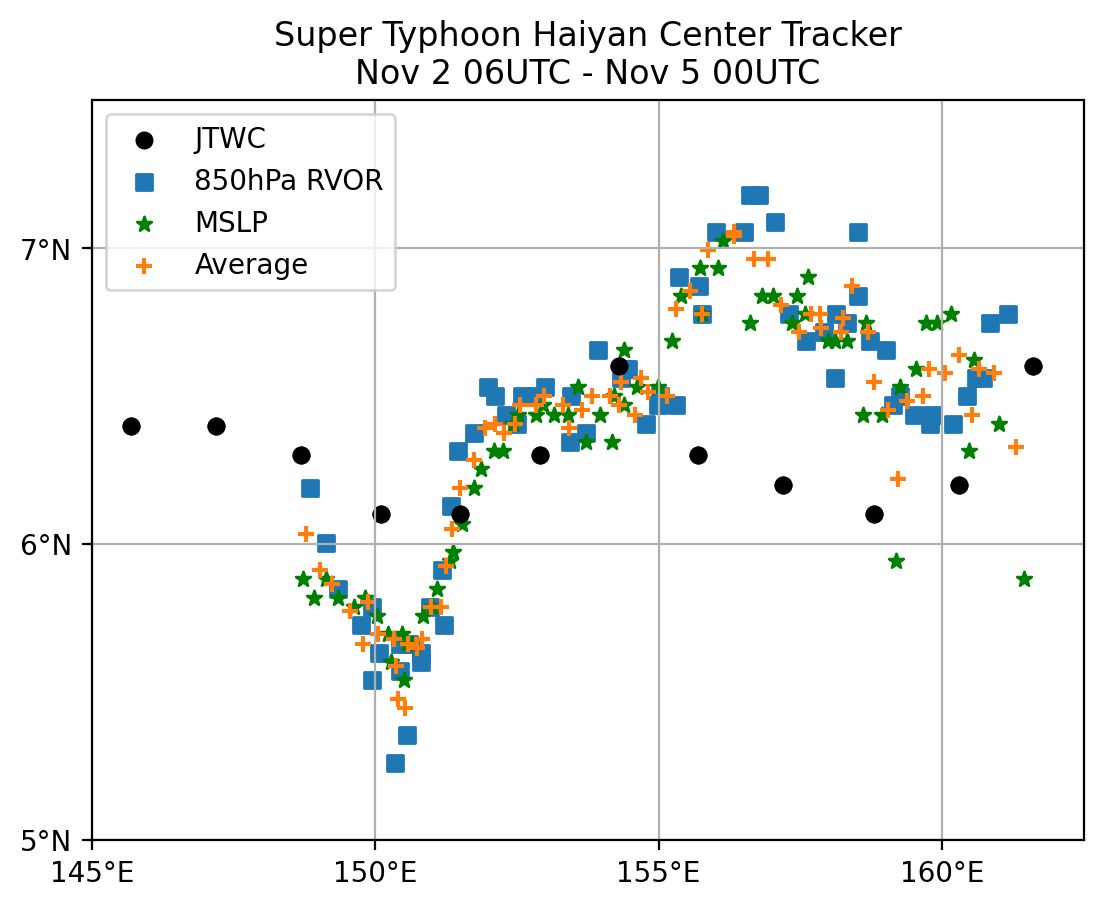

In [9]:
TC_center_coords_values_avg = (TC_center_coords_values_RVOR+TC_center_coords_values_SLP)/2
num = 30
plt.scatter(JTWC_track['lon'][:12],JTWC_track['lat'][:12], c='k', s=num)
plt.scatter(TC_center_coords_values_RVOR[30:,1],TC_center_coords_values_RVOR[30:,0], s=num, marker='s')
plt.scatter(TC_center_coords_values_SLP[30:,1],TC_center_coords_values_SLP[30:,0], s=num, c='g', marker='*')
plt.scatter(TC_center_coords_values_avg[30:,1],TC_center_coords_values_avg[30:,0], s=num, marker='+')
plt.scatter(JTWC_track['lon'][:12],JTWC_track['lat'][:12],c='k', s=num)
plt.grid(which='major',axis='both')
plt.legend(['JTWC','850hPa RVOR','MSLP','Average'],loc='upper left')
plt.title('Super Typhoon Haiyan Center Tracker\nNov 2 06UTC - Nov 5 00UTC')
plt.ylim((5,7.5))
plt.xlim((145,162.5))
x_tick_labels = [u'145\N{DEGREE SIGN}E',u'150\N{DEGREE SIGN}E',u'155\N{DEGREE SIGN}E',u'160\N{DEGREE SIGN}E']
plt.xticks([145,150,155,160],labels=x_tick_labels)
y_tick_labels = [u'5\N{DEGREE SIGN}N',u'6\N{DEGREE SIGN}N',u'7\N{DEGREE SIGN}N']
plt.yticks([5,6,7],labels=y_tick_labels)

plt.show()

### TC Vmax and MSLP evolution

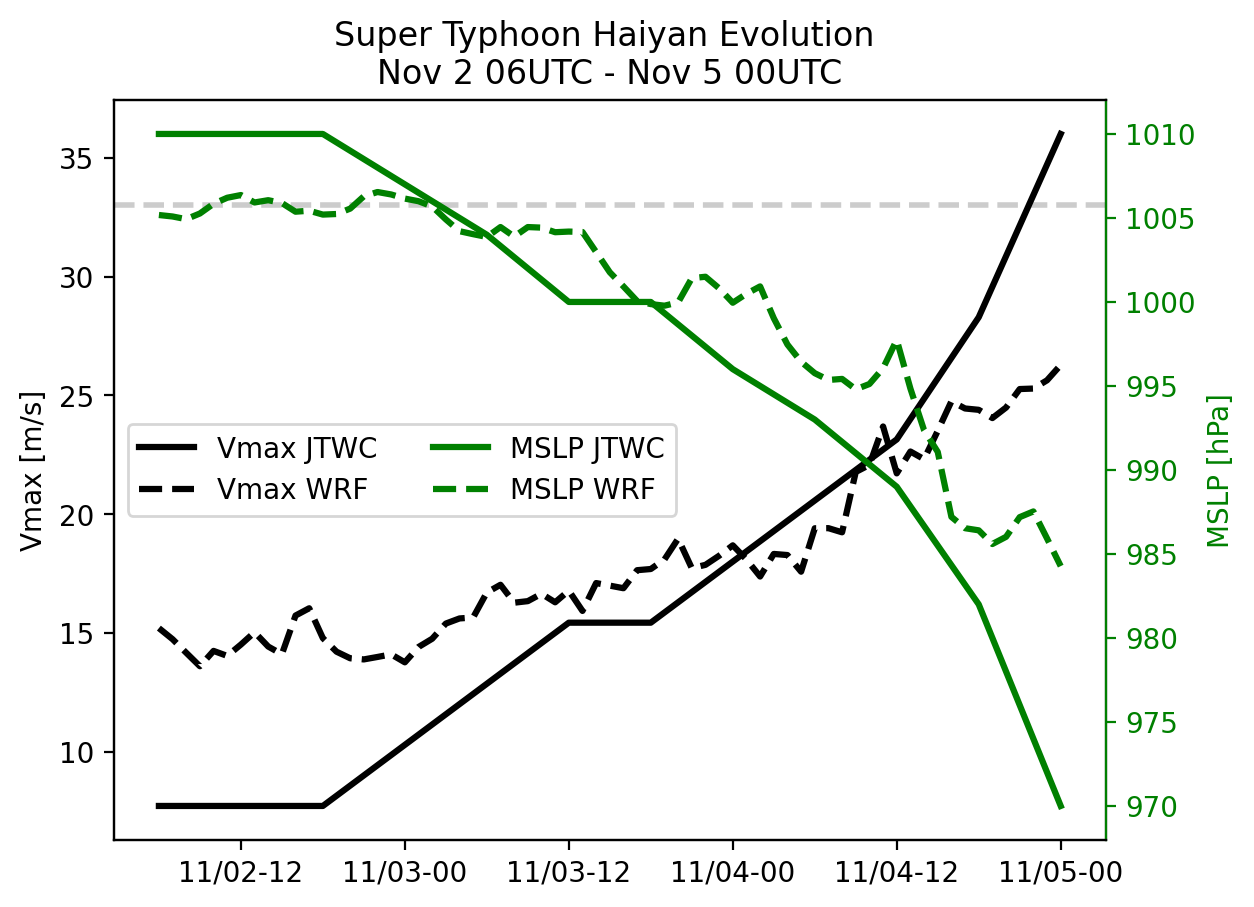

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

num = 2.25	# thickness of lines
a = ax1.plot(np.arange(len(JTWC_track['date'][:12]))*6,JTWC_track['vmax'][:12], 'k', linewidth=num, label='Vmax JTWC')
b = ax1.plot(np.arange(len(timesteps[30:])),TC_vmax[30:], '--k', linewidth=num, label='Vmax WRF')
c = ax2.plot(np.arange(len(JTWC_track['date'][:12]))*6,JTWC_track['mslp'][:12], 'g', linewidth=num, label='MSLP JTWC')
d = ax2.plot(np.arange(len(timesteps[30:])),TC_mslp[30:], '--g', linewidth=num, label='MSLP WRF')

plt.title('Super Typhoon Haiyan Evolution \nNov 2 06UTC - Nov 5 00UTC')
points = a+b+c+d
labs = [l.get_label() for l in points]
ax1.legend(points, labs, loc='center left', ncol=2)
ax1.axhline(y=33, color='k', linestyle='--',linewidth=2,alpha=0.2)
ax1.set_ylabel('Vmax [m/s]', color='k')
ax2.set_ylabel('MSLP [hPa]', color='g')
ax2.yaxis.label.set_color('g')
ax2.tick_params(axis='y', colors='g')
ax2.spines['right'].set_color('g')
x_tick_labels=TC_vmax.time[30::6][1::2].dt.strftime("%m/%d-%H").values
ax1.set_xticks(np.arange(6,78,12),labels=x_tick_labels)

plt.show()

### Create TC centered datasets

In [40]:
r=300
dx=3
TC_center_da = xr.DataArray(
		data = np.zeros([da_d02_RR.shape[0],int((r/dx)*2),int((r/dx)*2)]),	# Box center [Time x diameter x diameter]
		dims = ['time','x','y'],
		coords = dict(
			time = ('time',timesteps),
			x = ('x', np.arange(-r,r,dx)),
			y = ('y', np.arange(-r,r,dx))
		)
)
TC_center_da
np.zeros([da_d02_RR.shape[0],2]).shape

/tmp/ipykernel_24510/1367455896.py:3: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  TC_center_da = xr.DataArray(


(97, 2)

In [213]:
# da:		 Should be a data array with time, lat, lon, and if it has levels, then 3D must be set to True	[xr.DataArray]
# r: 		 The radius that you want to look at from the TC	[km]
# TC_center: An array with coordinates of the TC 				[lat,lon]
# dx:		 The gridspacing used 	e.g., dx=3 if 3 km  grid spacing [km]

def da_centered_on_TC(da, r, TC_center, dx):
	center_idx = np.zeros([da.shape[0],2], dtype=int)	# Declare int dtype
	for i in range(center_idx.shape[0]):	# loop through all the times
		center_idx[i,0] = np.argmin(abs(TC_center[i,0]-da.lat.values))
		center_idx[i,1] = np.argmin(abs(TC_center[i,1]-da.lon.values))

	if 'levels' in da.dims:	# If the dataset is 3-D
		box_center = np.zeros([da.shape[0],da.shape[1],int((r/dx)*2),int((r/dx)*2)])
		for i in range(center_idx.shape[0]):	# loop through all the times
			x_idx = np.arange(center_idx[i,0]-(r/dx),center_idx[i,0]+(r/dx),dtype=int)
			y_idx = np.arange(center_idx[i,1]-(r/dx),center_idx[i,1]+(r/dx),dtype=int)
			box_center[i,:,:,:] = da[i,:,x_idx,y_idx]
	else:
		box_center = np.zeros([da.shape[0],int((r/dx)*2),int((r/dx)*2)])
		for i in range(center_idx.shape[0]):	# loop through all the times
			x_idx = np.arange(center_idx[i,0]-(r/dx),center_idx[i,0]+(r/dx),dtype=int)
			y_idx = np.arange(center_idx[i,1]-(r/dx),center_idx[i,1]+(r/dx),dtype=int)
			box_center[i,:,:] = da[i,x_idx,y_idx]
	
	# Initialize the DataArray
	TC_center_da = xr.DataArray(
		data = box_center,	# Box center [Time x diameter x diameter]
		dims = ['time','y','x'],
		coords = dict(
			time = ('time',timesteps),
			x = ('x', np.arange(-r,r,dx)),
			y = ('y', np.arange(-r,r,dx))
		)
	)
	return TC_center_da

r = 600
dx = 3
TC_center = TC_center_coords_values_avg

da = da_d02_RR
da_TCC_RR = da_centered_on_TC(da, r, TC_center, dx)

/tmp/ipykernel_24510/1852450025.py:26: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  TC_center_da = xr.DataArray(


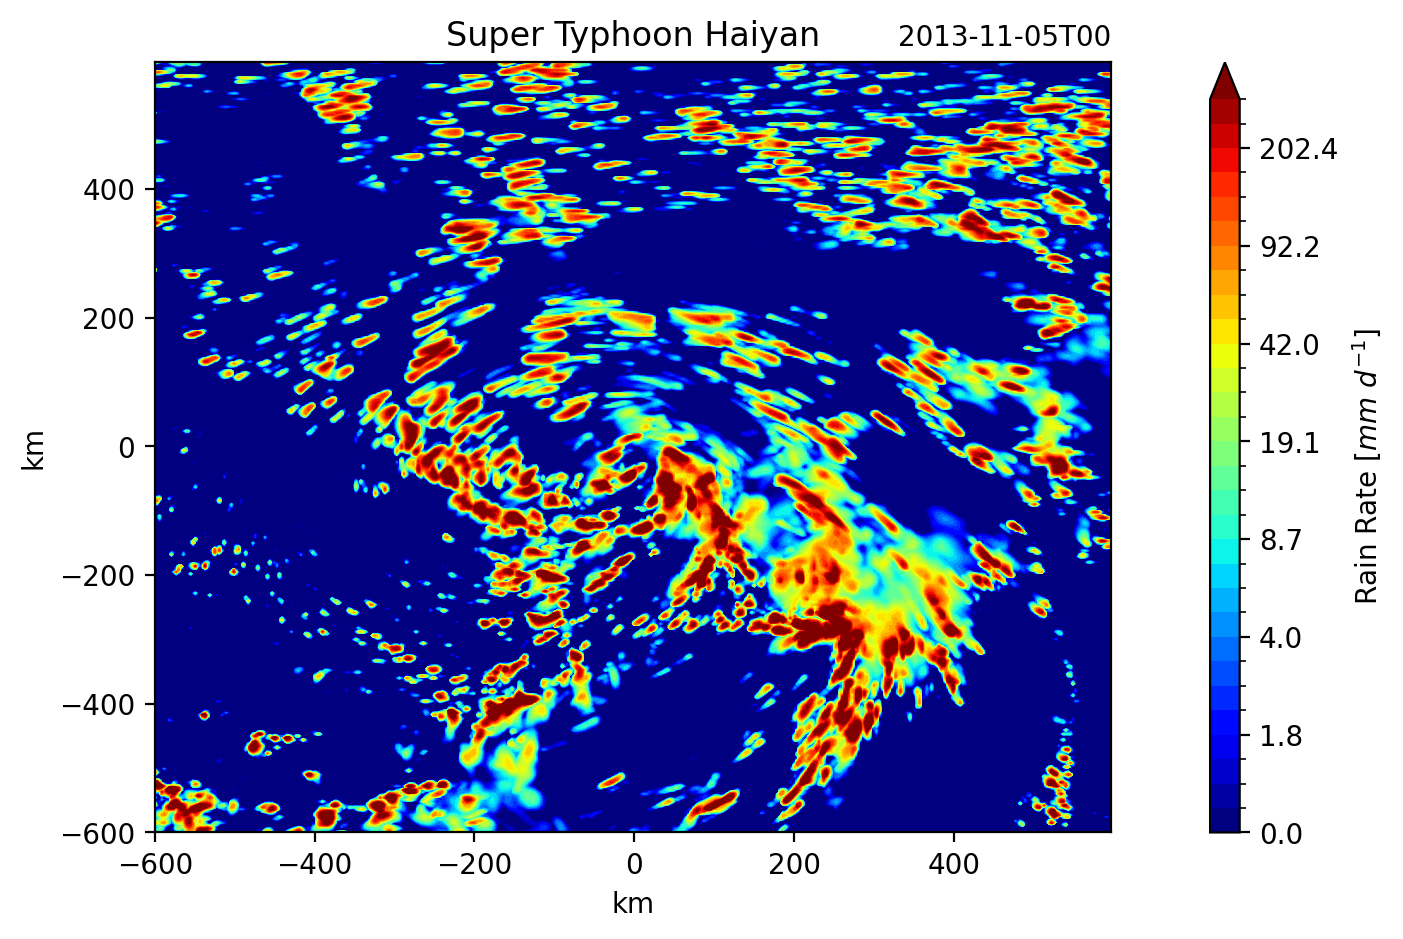

In [220]:
i = 96
fig = plt.figure(figsize=(7,5))

gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[.97,.03])
ax1 = fig.add_subplot(gs[0,0])

local_time = da_TCC_RR.time + np.timedelta64(10,'h')
da_TCC_RR = da_TCC_RR.assign_coords(
	local_time=('time',local_time.values)
)
x = da_TCC_RR.groupby('time.hour').mean()

cf1 = (da_TCC_RR[54,:,:]).plot.contourf(
	ax=ax1,
	add_colorbar=False,
	cmap='jet',
	# levels=np.arange(0,300,10),
	levels=np.append(0,np.logspace(0,math.log(300,10),30)),
)

ax1.set_title('Super Typhoon Haiyan',loc='center', fontsize=12)
# ax1.set_title('Rain rate',loc='left', fontsize=10)
ax1.set_title(str(timesteps[i]),loc='right', fontsize=10)
ax1.set_xlabel('km')
ax1.set_ylabel('km')

ax2 = fig.add_subplot(gs[0,1])
cbar = plt.colorbar(cf1, cax=ax2, orientation='vertical', extend='max')
cbar.set_label('Rain Rate [$mm$ $d^{-1}$]')

## Random Visualization

In [ ]:
fig = plt.figure(figsize=(9,5))
lon_bound_d02 = [145,170]
lat_bound_d02 = [0,10]
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=1, ncols=2,width_ratios=[.97,.03])

ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound_d02[0], lat_bound_d02[1]], ccrs.PlateCarree(central_longitude=0))
ax1.coastlines(linewidth=3, color='k', resolution='50m')  # cartopy function

# ax1.set_xticks([145,150,155])
# x_tick_labels = [u'145\N{DEGREE SIGN}E',u'150\N{DEGREE SIGN}E',u'155\N{DEGREE SIGN}E']
# ax1.set_xticklabels(x_tick_labels)
# y_tick_labels = [u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N',u'7.5\N{DEGREE SIGN}N']
# ax1.set_yticklabels(y_tick_labels)
# ax1.set_yticks([2.5,5,7.5])

# Plot the last time step of the available data
# cf1 = da_d02_RR[25,:,:].plot.contourf(
# 	ax=ax1,
# 	add_colorbar=False,
# 	cmap='jet',
# 	levels=np.arange(0,75,5)
# )
cf1 = (a[30,:,:]*10**5).plot.contourf(
	ax=ax1,
	add_colorbar=False,
	cmap='jet',
	# levels=np.arange(0,75,5)
)

ax1.set_title('WRF rain rate [mm/hr]',loc='left')
ax1.set_title(str(timesteps[95]),loc='center')
ax1.set_xlabel('')
ax1.set_ylabel('')

ax2 = fig.add_subplot(gs[0,1])
cbar = plt.colorbar(cf1, cax=ax2, orientation='vertical', extend='max')
cbar.set_label('Rain Rate [$mm hr^{-1}$]')


#### Diurnal rain rate evolution 

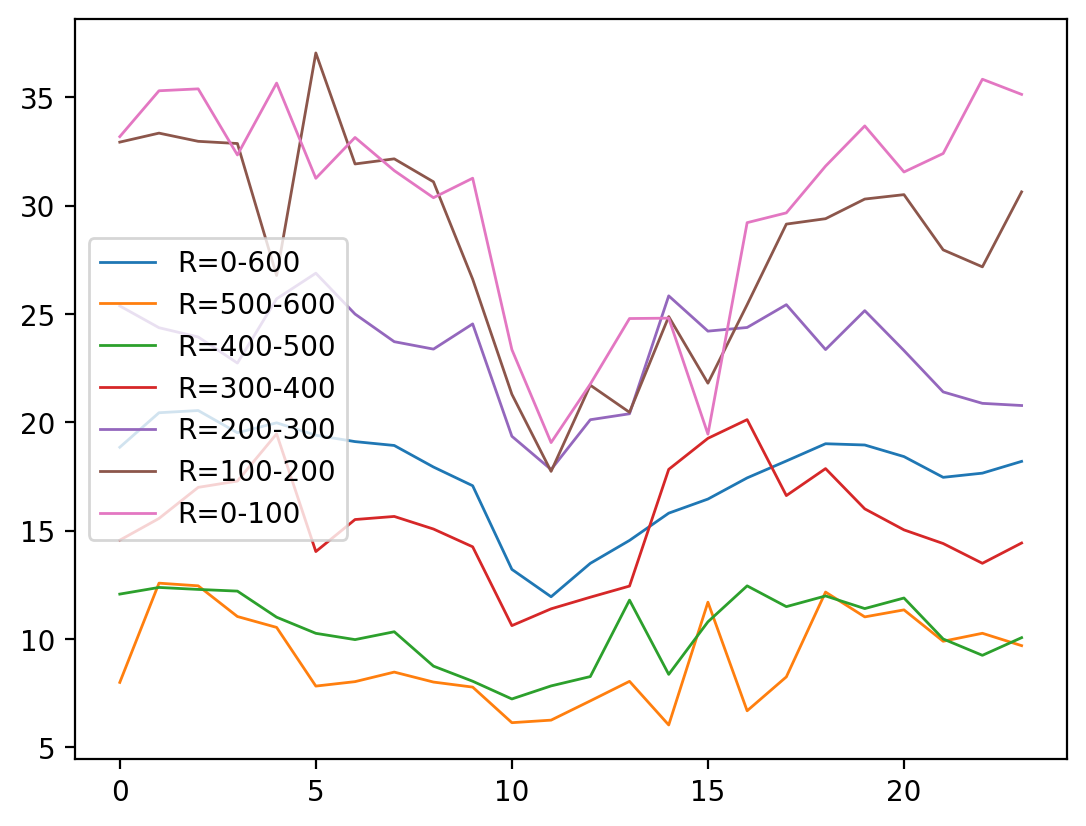

In [209]:
# Create a local time coordinate
	# The region where the TC is located is about 10 hrs ahead of UTC
local_time = da_TCC_RR.time + np.timedelta64(10,'h')
da_TCC_RR = da_TCC_RR.assign_coords(
	local_time=('time',local_time.values)
)
a = da_TCC_RR.groupby('local_time.hour').mean()
b = a.mean(dim=['y','x'])
c = a.where((abs(a.x)<600)&(abs(a.x)>=500)).mean(dim=['y','x'])
d = a.where((abs(a.x)<500)&(abs(a.x)>=400)).mean(dim=['y','x'])
e = a.where((abs(a.x)<400)&(abs(a.x)>=300)).mean(dim=['y','x'])
f = a.where((abs(a.x)<300)&(abs(a.x)>=200)).mean(dim=['y','x'])
g = a.where((abs(a.x)<200)&(abs(a.x)>=100)).mean(dim=['y','x'])
h = a.where((abs(a.x)<100)&(abs(a.x)>=0)).mean(dim=['y','x'])
fig, ax1 = plt.subplots()
num = 1
r0_600=ax1.plot(b.hour, b, linewidth=num, label='R=0-600')
r500_600=ax1.plot(c.hour, c, linewidth=num, label='R=500-600')
r400_500=ax1.plot(d.hour, d, linewidth=num, label='R=400-500')
r300_400=ax1.plot(e.hour, e, linewidth=num, label='R=300-400')
r200_300=ax1.plot(f.hour, f, linewidth=num, label='R=200-300')
r100_200=ax1.plot(g.hour, g, linewidth=num, label='R=100-200')
r0_100=ax1.plot(h.hour, h, linewidth=num, label='R=0-100')

points = r0_600+r500_600+r400_500+r300_400+r200_300+r100_200+r0_100
labs = [l.get_label() for l in points]
ax1.legend(points, labs, loc='center left')